In [15]:
import torch
import torchvision 
import torch.nn.functional as F  
import torchvision.datasets as datasets  
import torchvision.transforms as transforms  
from torch import optim  
from torch import nn  
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import matplotlib as mpl
from matplotlib.lines import Line2D

## Visualizing a few images

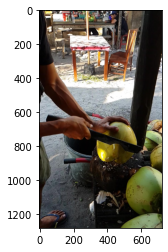

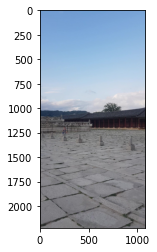

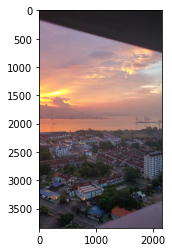

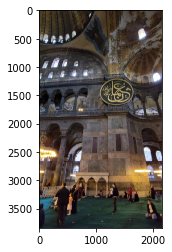

In [2]:
#Getting frames
DATADIR = "Desktop\Dataset"
CATEGORIES = ["Bali", "Korea", "Malaysia", "Turkey"]

#Visualizing a picture from each category:
for category in CATEGORIES:  
    path = os.path.join(DATADIR,category) 
    for img in random.sample(list(tqdm(os.listdir(path), disable=True)),1): 
        img_array = cv2.imread(os.path.join(path,img) ) 
        plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        plt.show()  
     

## Create train and test data

In [3]:
# iterate over image per category and store 1000 images and their labels

def create_data(IMG_SIZE):
    training_data,test_data,data = [],[],[]
    for category in CATEGORIES:
        path = os.path.join(DATADIR,category)  
        class_num = CATEGORIES.index(category)
        images=list(tqdm(os.listdir(path)))[:1000] 

        for img in images:  
            try:
                img_array = cv2.imread(os.path.join(path,img) ) 
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
                data.append([new_array, class_num])  
            except Exception as e:  
                pass
     
        training_data=training_data+data[100:] 
        test_data=test_data+data[:100]
        data=[]
        
    #Get train and test sets 
   
    return(training_data,test_data)
    

IMG_SIZE=32    
training_data,test_data=create_data(IMG_SIZE)
#Using GPU when available
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Shuffle data to prevent a biased training
random.shuffle(training_data)
random.shuffle(test_data)


100%|██████████████████████████████████████████████████████████████████████████████████████| 1245/1245 [00:00<?, ?it/s]


## Helpful methods:

In [4]:

#Data preparation methods:
def prepare_data(data_set):
    
    X = []
    y = []

    for features,label in data_set:
        X.append(features)
        y.append(label)
    X = np.array(X)
    X = X/255.0
    X=X.reshape(-1, 3 ,IMG_SIZE, IMG_SIZE)
    X=torch.tensor(X)
    y=torch.tensor(y)
    
    x1=[]
    y1=[]
    for x in batch(X, 16):
        x1.append(x)

    for x in batch(y, 16):
        y1.append(x)


    X=torch.stack(x1)
    y=torch.stack(y1) 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = sequential.to(device)
    model.double()
    X=X.to(device)
    y=y.to(device)
    
    return(X,y)

def batch(iterable, n):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]
        
        
#Model evaluation function:

def check_accuracy( model,X,Y):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for i in range (len(X)):
            x=X[i]
            y=Y[i]
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)


    model.train()
    return num_correct/num_samples


## Create and train the model

In [66]:
#The neural network

sequential = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
    , nn.MaxPool2d(kernel_size=2, stride=2)
    , nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
    , nn.MaxPool2d(kernel_size=2, stride=2)
    , nn.Flatten(start_dim=1)  
    , nn.Linear(in_features=5*5*12, out_features=128)
    , nn.ReLU()
    , nn.Linear(in_features=128, out_features=32)
    , nn.ReLU()
    , nn.Linear(in_features=32, out_features=4)
    , nn.Softmax(dim=1)

)
#Train the model
epochs=5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = sequential.to(device)
model.double()
optimizer = optim.Adam(model.parameters())

#Create value and label tensors
X,y=prepare_data(training_data)

for epoch in range(epochs):
    
    for i in range (len(X)):

        optimizer.zero_grad()
        output = model(X[i])
        loss = F.nll_loss(output, y[i])
        loss.backward()
        optimizer.step()

## Evaluate the model

In [67]:
print(f"Accuracy on training set is {check_accuracy(model,X,y).item()*100:.2f} %")
X,y=prepare_data(test_data)
print(f"Accuracy on testing set is {check_accuracy(model,X,y).item()*100:.2f} %")

Accuracy on training set is 98.31 %
Accuracy on testing set is 96.50 %


## Prepare a test sample for visualization

In [68]:
arrays=[]
images=[]
for category in CATEGORIES:  
    path = os.path.join(DATADIR,category) 
    for img in random.sample(list(tqdm(os.listdir(path), disable=True)),4):  
        
        img_array = cv2.imread(os.path.join(path,img) )
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) 
        images.append(img_array)
        arrays.append(new_array)
        
#Create visual representation:
x1=[]
X = np.array(arrays)
X = X/255.0
X=X.reshape(-1, 3 ,IMG_SIZE, IMG_SIZE)
X=torch.tensor(X)

for x in batch(X, 16):
    x1.append(x)
    
X=torch.stack(x1)[0]
X=X.to(device)

with torch.no_grad():
    scores = model(X)

results=np.array(torch.Tensor.cpu(scores.max(1).indices))
dictionary = {"Bali" : 0, "Korea":1, "Malaysia":2, "Turkey":3}

## Visualize the results

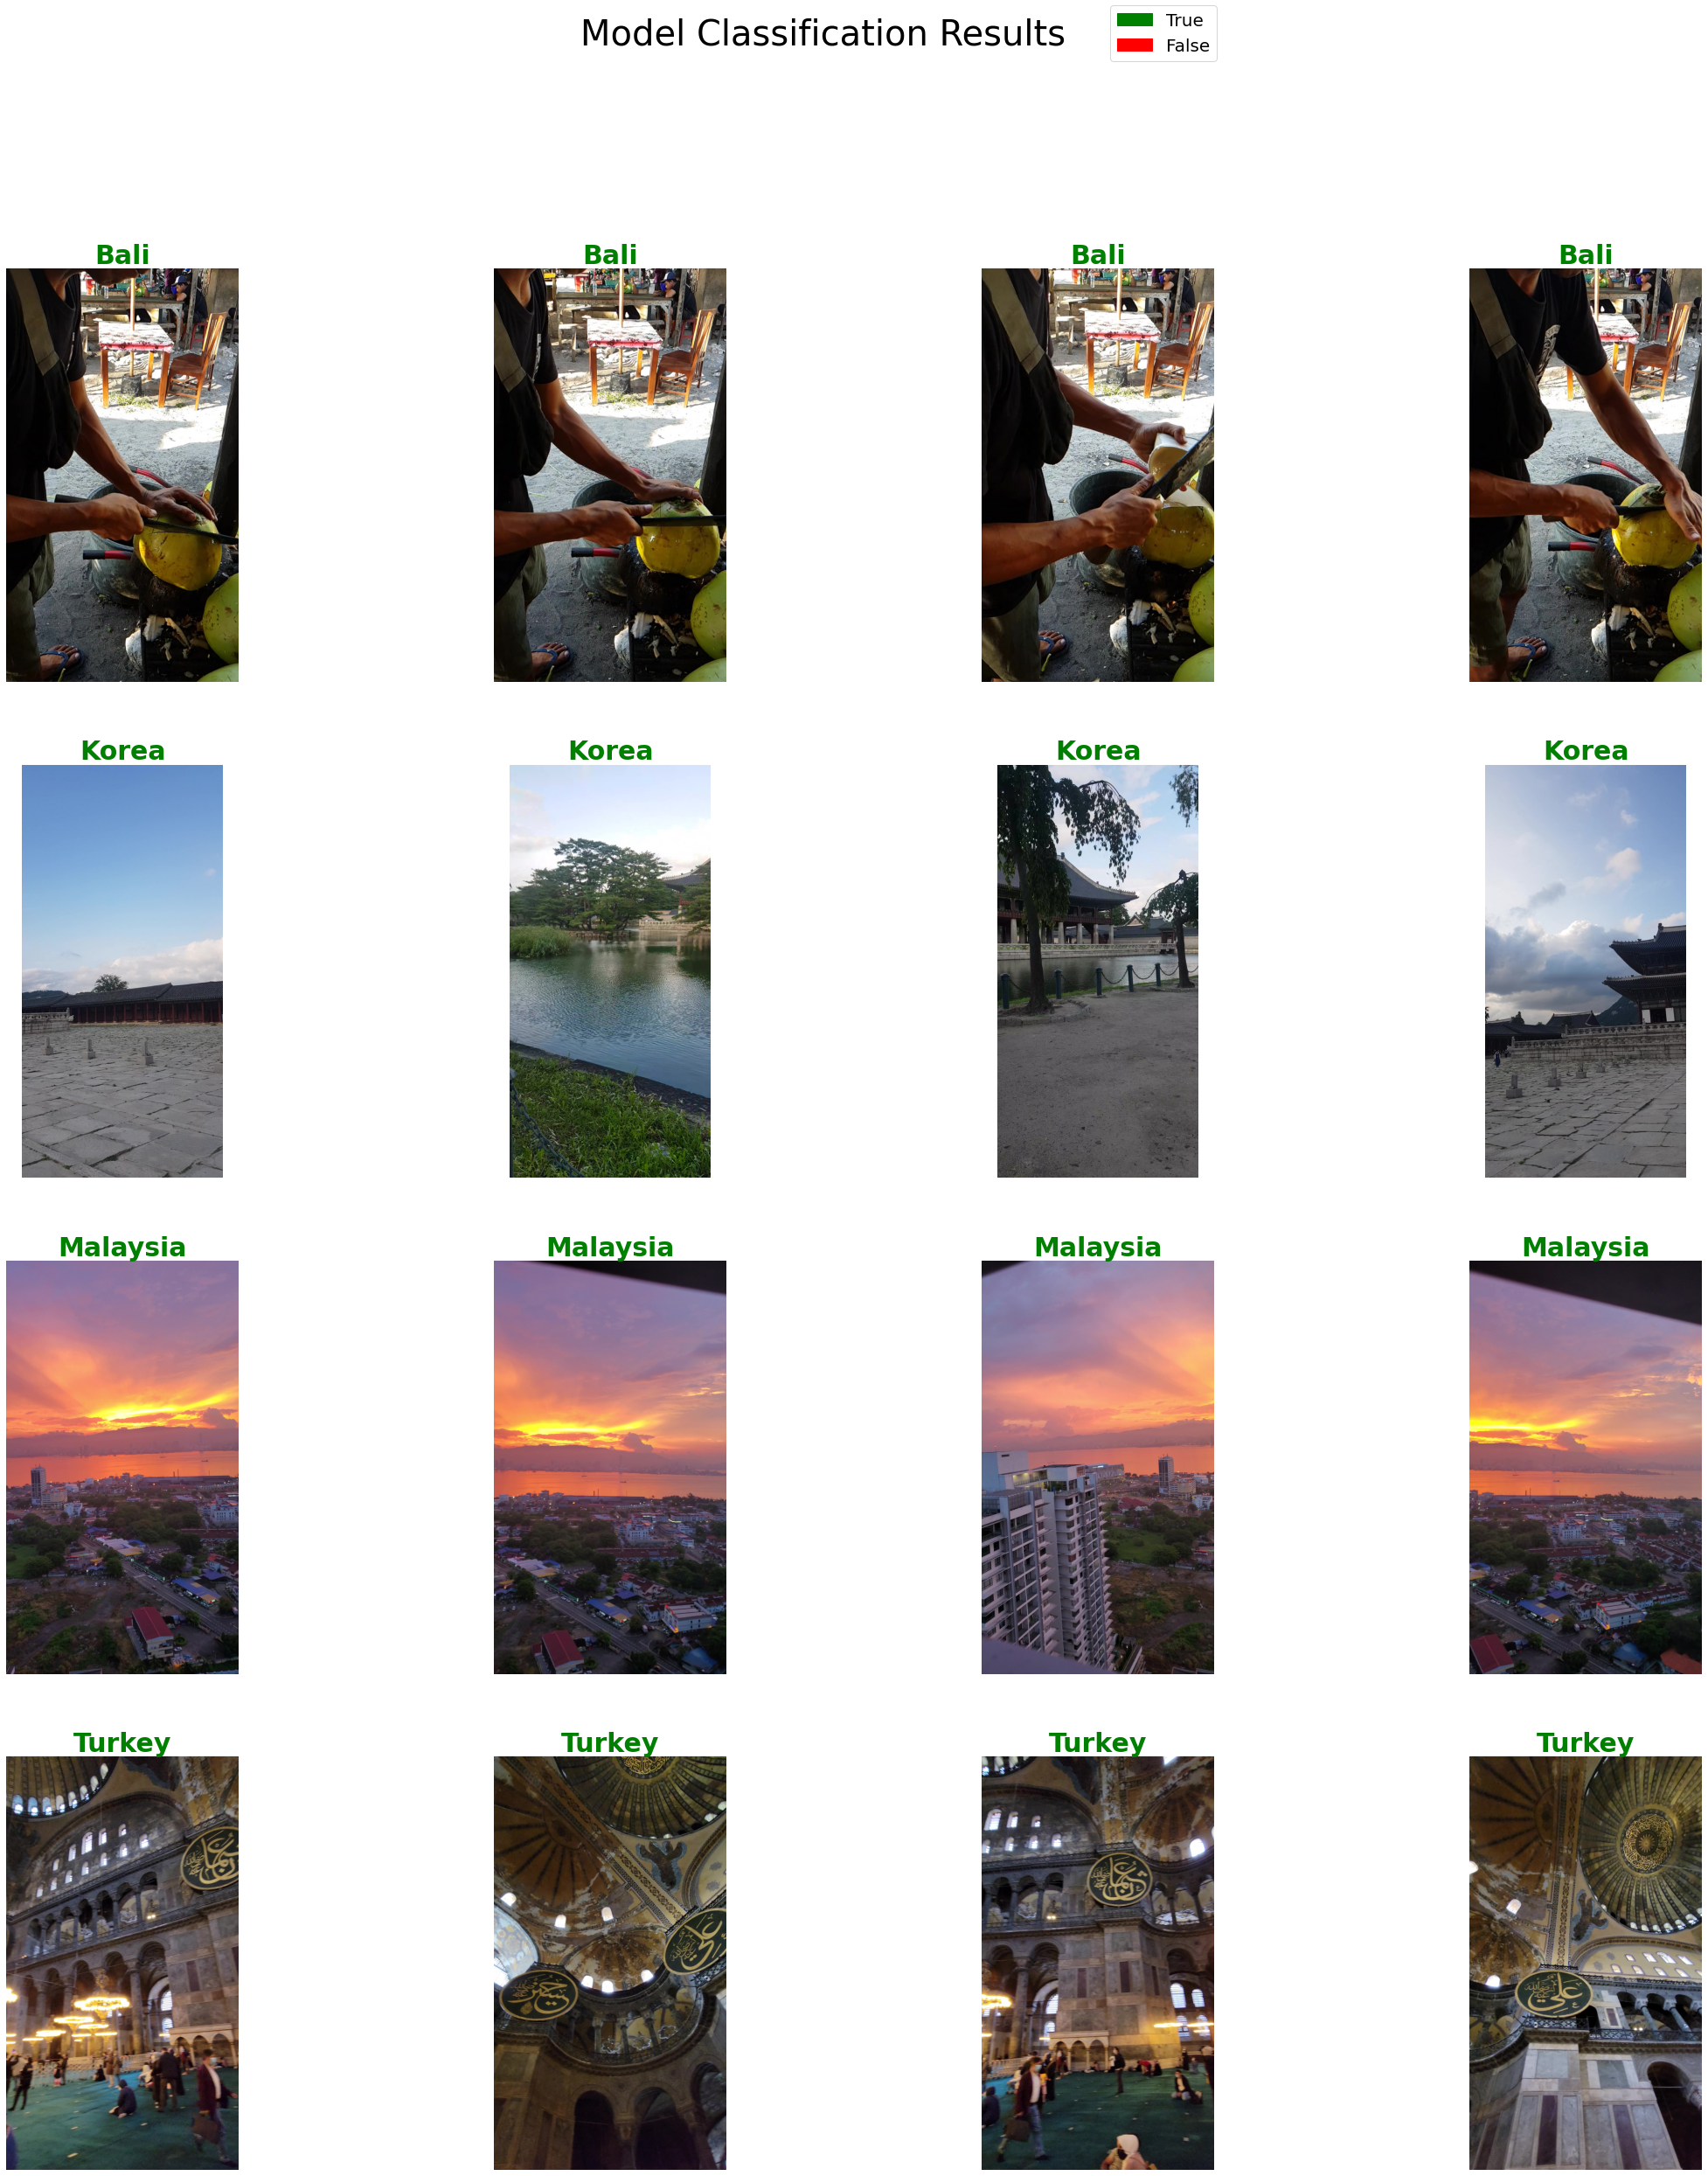

In [72]:
from matplotlib.patches import Patch
#Plot test sample
fig, axs = plt.subplots(4, 4, figsize=(40, 40))

custom_lines = [Patch(facecolor='green', edgecolor='g'),
                Patch(facecolor='red', edgecolor='red')]

#
for i in range(16):
    
    axs[i//4, i%4].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    axs[i//4, i%4].set_title(list(dictionary.keys())[results[i]], 
                             color='green' if (results[i]==(i//4)) else 'red', 
                             fontsize= 30, fontweight='bold')
    axs[i//4, i%4].axis('off')
    
fig.suptitle('Model Classification Results', fontsize=40)
fig.legend(custom_lines, ['True', 'False'],fontsize= 20, bbox_to_anchor=(0.66, 0.988))
fig.subplots_adjust(wspace=0)

plt.show()

    

## Discussion:

##### This model acheived a high accuracy rate with a small training sets due to the fact that all pictures are relatively similar to each other (frames of the same video). In this particular sample, the model manages to accurately identify each location the frames belong to. That is, on average we can accurately identify pictures at a ratio of 15.44 frames in each batch of 16.